## Try to get time iteration direct working

We want the possibility of using time iteration direct because it is much faster than time iteration, which will speed up the computation of equilibrium massively. 

In [1]:
# Setup
import numpy as np
import scipy.sparse as spa

from dolo import yaml_import
from dolo.algos.dtcscc.time_iteration import time_iteration, time_iteration_direct
import dolo.algos.dtcscc.distributions_general as dst
from dolo.numeric.misc import mlinspace
from dolo.numeric.discretization.quadrature import gauss_hermite_nodes
from dolo.numeric.discretization.discretization import rouwenhorst


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
filename = 'incomplete_markets_dtcscc.yaml'
model = yaml_import(filename)

Nf = np.array([100, 9])

### Solve using time iteration and plot decision rules

In [3]:
dr = time_iteration_direct(model,with_complementarities=True, verbose=False)

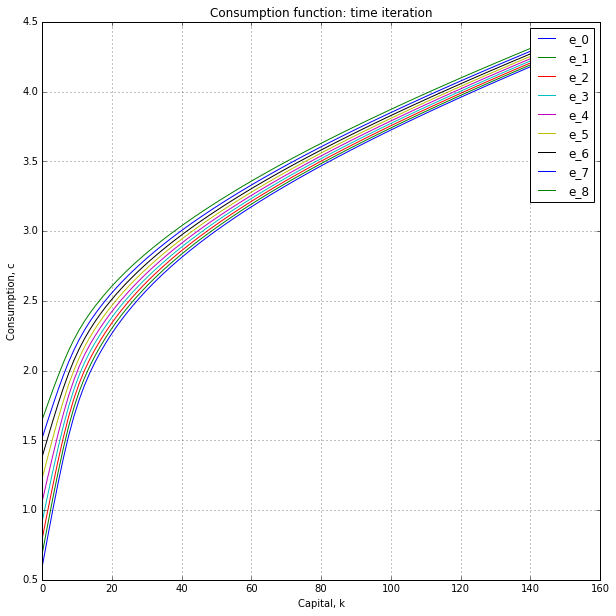

In [12]:

Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
# drc_direct = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()
#     drc_direct[:, i_e] = dr_direct(sgridf).flatten()

%matplotlib inline

plt.figure(figsize=(10, 10))
for i_e in range(Nf[1]):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function: time iteration')
plt.legend()
plt.grid()


### Compute stationary distribution 

In [13]:
L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.276142 

Iteration = 100, dist = 0.006243 

Iteration = 200, dist = 0.001596 

Iteration = 300, dist = 0.000291 

Iteration = 400, dist = 0.000050 

Iteration = 500, dist = 0.000008 

Iteration = 600, dist = 0.000001 

Iteration = 700, dist = 0.000000 

Iteration = 800, dist = 0.000000 



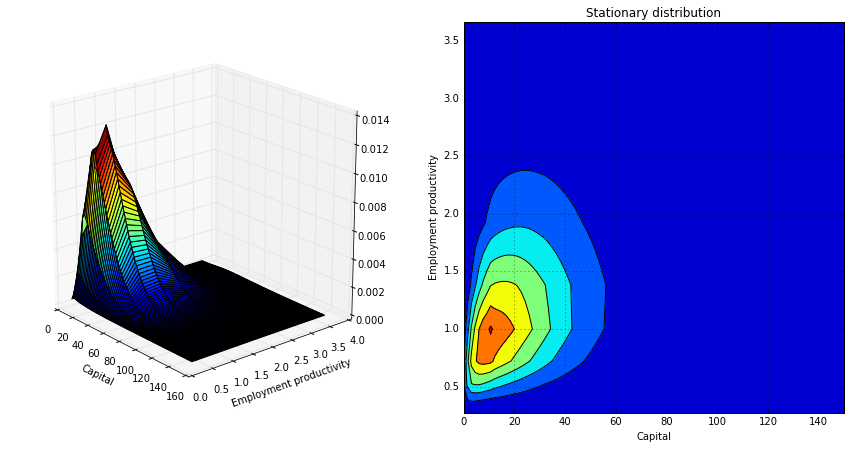

In [14]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf],order='F')    # Need Fortran order since variables are in a different order
sgridf = dst.fine_grid(model, Nf)
kgridf = np.unique(sgridf[:,0])
egridf = np.unique(sgridf[:,1])
# kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(15, 7))
# plt.subplot(121)
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 320

ax = fig.add_subplot(122)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()

### Solve equilibrium using damping method

Works well for most accuracy levels. Time ~ 12.7s. 

In [17]:
K = dst.eqm_damping(model, Nf, 'k', 'kagg', 50, itermax=100, toleq=1e-4, verbose=False)
K

42.603440908664325

### Solve equilibrium using bisection method

Works fairly well. Time ~ 15.9s

Takes fewer iterations than damping, however, each iteration requires two computations of the decision rule and the stationary distribution. Damping only requires one of each per iteration.  

In [19]:
K = dst.eqm_bisection(model, Nf, 'k', 'kagg', [40,70], itermax=100, toleq=1e-4, verbose=False)
K

42.60284423828125

### Solve for supply and demand


In [3]:
Kd, Ks, r = dst.supply_demand(model, 'k', 'kagg', 'r', Nf, lower=40, upper=60, numpoints=30, verbose=True)

Iteration = 	0
Iteration = 	5
Iteration = 	10
Iteration = 	15
Iteration = 	20
Iteration = 	25


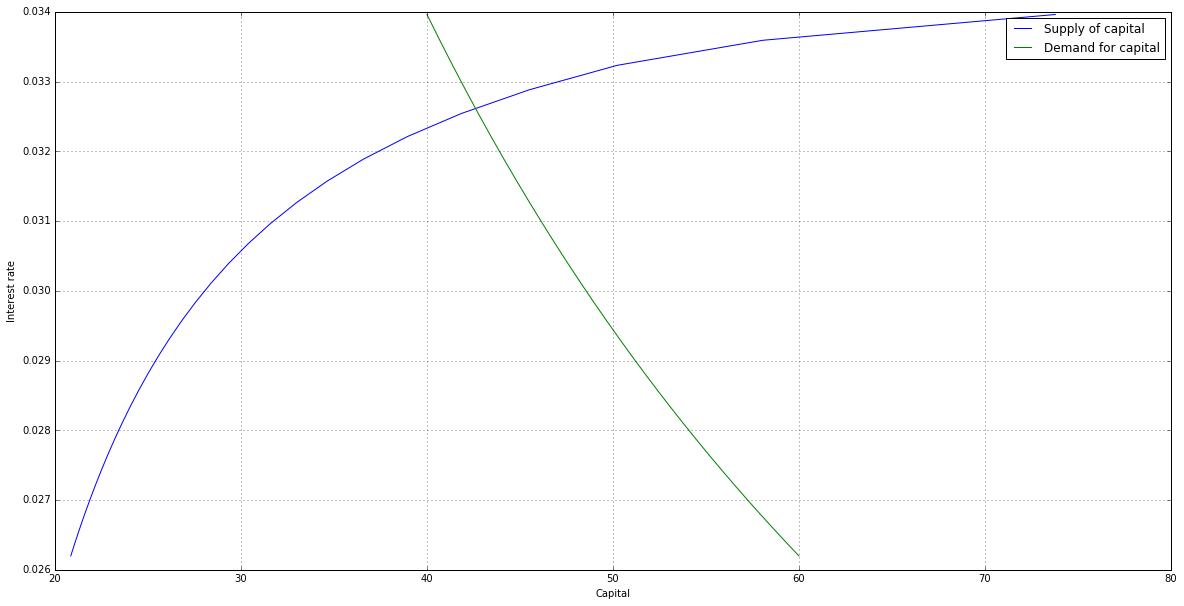

In [5]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
# plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
# plt.ylim(0.027, 0.034)
# plt.xlim(20, 70)

### Using equilibrium aggregate capital stock, compute decision rules and stationary distribution

In [34]:
model.set_calibration(kagg=K)
dr = time_iteration_direct(model, with_complementarities=True, verbose=False) 
L, QT = dst.stat_dist(model, dr, Nf, itmaxL=5000, tolL=1e-8, verbose=True)

Iteration = 0, dist = 0.275975 

Iteration = 100, dist = 0.003141 

Iteration = 200, dist = 0.001677 

Iteration = 300, dist = 0.000842 

Iteration = 400, dist = 0.000399 

Iteration = 500, dist = 0.000186 

Iteration = 600, dist = 0.000086 

Iteration = 700, dist = 0.000040 

Iteration = 800, dist = 0.000018 

Iteration = 900, dist = 0.000009 

Iteration = 1000, dist = 0.000004 

Iteration = 1100, dist = 0.000002 

Iteration = 1200, dist = 0.000001 

Iteration = 1300, dist = 0.000000 

Iteration = 1400, dist = 0.000000 

Iteration = 1500, dist = 0.000000 

Iteration = 1600, dist = 0.000000 

Iteration = 1700, dist = 0.000000 



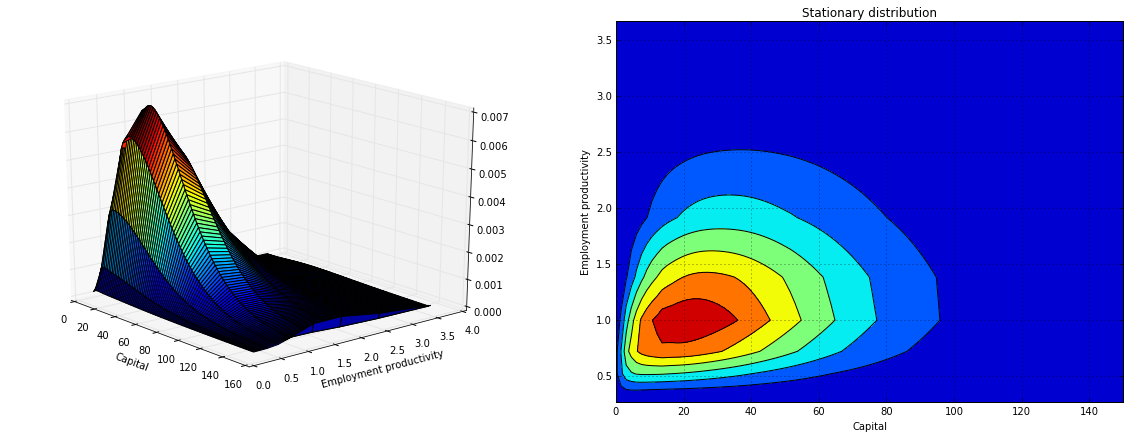

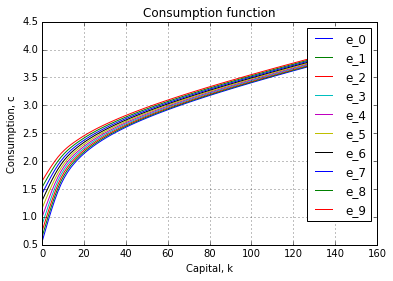

In [35]:
# 3D plot of the distribution
Nkf = Nf[0]
Nef = Nf[1]
Z = L.reshape([Nef, Nkf],order='F')    # Need Fortran order since variables are in a different order
sgridf = dst.fine_grid(model, Nf)
kgridf = np.unique(sgridf[:,0])
egridf = np.unique(sgridf[:,1])
# kgridf, egridf = dst.fine_grid(model, Nf)
X, Y = np.meshgrid(kgridf, np.exp(egridf))

fig = plt.figure(figsize=(20, 15))
# plt.subplot(121)
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = cm.jet)
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
ax.elev = 20
ax.azim = 320

ax = fig.add_subplot(222)
contour = plt.contour(X, Y, Z, colors='k')
cp = plt.contourf(X, Y, Z)
plt.title('Stationary distribution')
plt.xlabel('Capital')
plt.ylabel('Employment productivity')
plt.grid()
plt.show()



Nk = 100
Nftmp = np.array([Nk,1])
egrid = np.unique(dr.grid[:,1])
Ne = egrid.shape[0]

drc = np.zeros([Nk, Ne])
for i_e in range(Ne):
    sgridf = mlinspace(np.array([min(dr.grid[:,0]), egrid[i_e]]), np.array([max(dr.grid[:,0]), egrid[i_e]]),Nftmp)
    drc[:, i_e] = dr(sgridf).flatten()

ax = fig.add_subplot(223)
for i_e in range(10):
    plt.plot(sgridf[:,0], drc[:,i_e],label='e_'+str(i_e))
plt.ylabel('Consumption, c')
plt.xlabel('Capital, k')
plt.title('Consumption function')
plt.legend()
plt.grid()

### Plot the equilibrium stationary distribution and decision rules

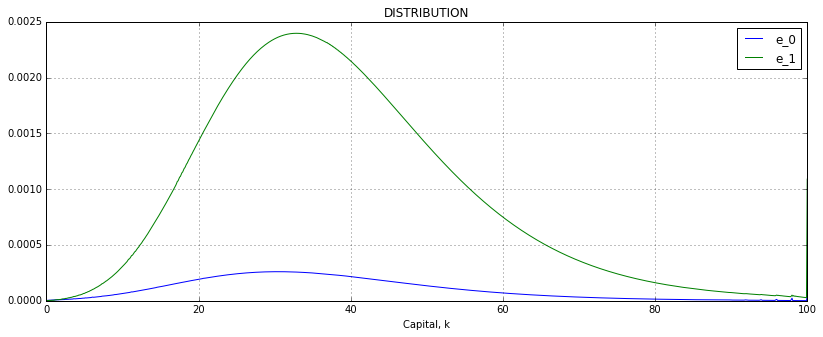

In [6]:
%matplotlib inline

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(kgridf, L[:Nkf],label='e_0')
plt.plot(kgridf, L[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('DISTRIBUTION')
plt.legend()
plt.grid()

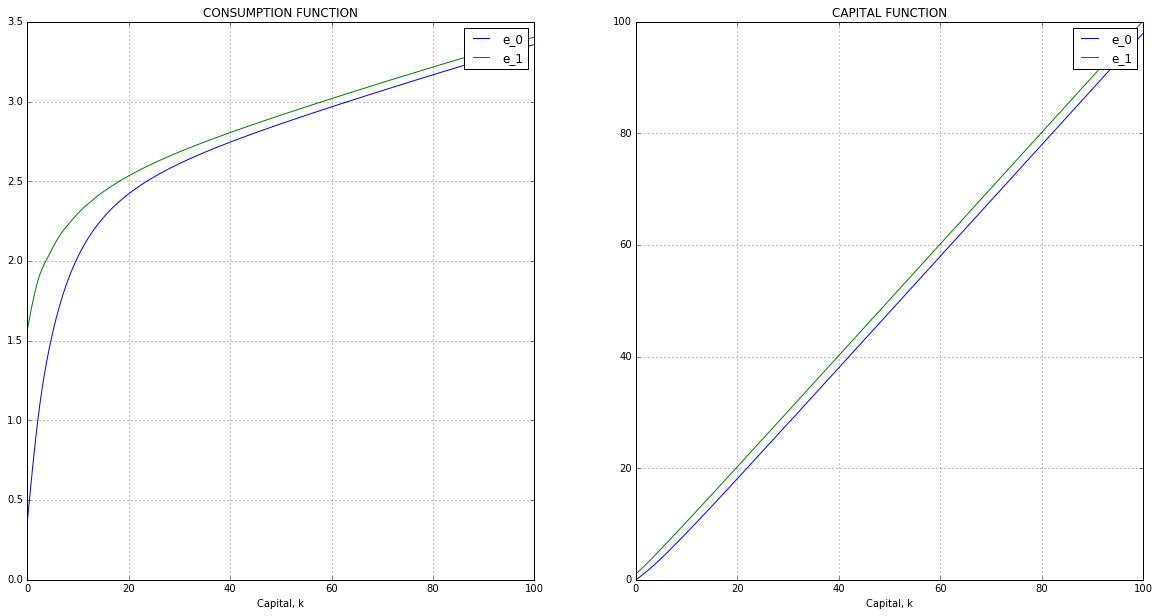

In [9]:
# Get kprime and consumption from the markov decision rule

kprimef = dst.mdr_to_sprime(model, mdr, Nkf)
mdrc = np.zeros([Nkf, Ne])
for i_m in range(Ne):
    mdrc[:, i_m] = mdr(i_m, kgridf.reshape(-1,1)).flatten()

# Plot controls

%matplotlib inline
kgrid = mdr.grid

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.plot(kgridf, mdrc[:,0],label='e_0')
plt.plot(kgridf, mdrc[:,1],label='e_1')
plt.xlabel('Capital, k')
plt.title('CONSUMPTION FUNCTION')
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(kgridf, kprimef[:Nkf],label='e_0')
plt.plot(kgridf, kprimef[Nkf:],label='e_1')
plt.xlabel('Capital, k')
plt.title('CAPITAL FUNCTION')
plt.legend()
plt.grid()

### Compute supply and demand curves using stat_dist function

In [ ]:
Kd, Ks, r = dst.supply_demand(model, Nkf=1000, numpoints=20, lower=37, upper=40, verbose=True)

(20, 60)

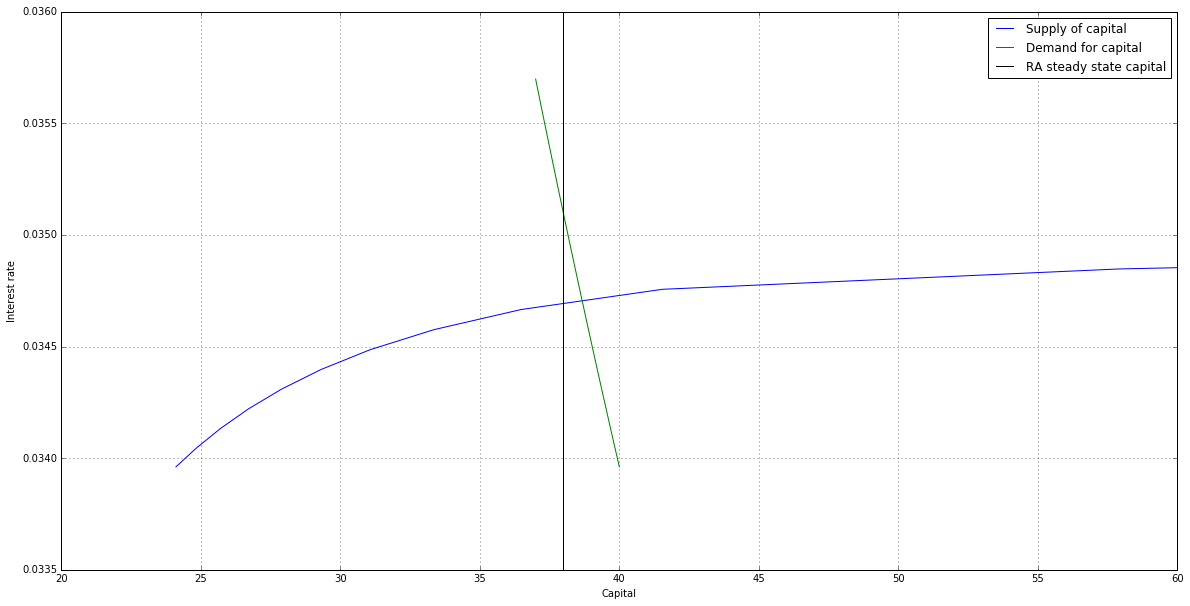

In [4]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
plt.plot(Ks, r,label='Supply of capital')
plt.plot(Kd, r,label='Demand for capital')
plt.plot((37.9893, 37.9893), (0.031, 0.036), 'k-', color='black', label='RA steady state capital')
plt.xlabel('Capital')
plt.ylabel('Interest rate')
plt.legend()
plt.grid()
plt.ylim(0.0335, 0.036)
plt.xlim(20, 60)

#### Create a function that takes transition back to control

For models in which we can use the $s_{t+1}$ trick, need to create a function that takes this transition rule back to the control. 